In [41]:
## Import necessary libraries here (You can add libraries you want to use here)
import cv2
import numpy as np
from scipy.io import loadmat
from scipy import ndimage
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
%matplotlib inline

# Part 1: A Feature Tracker (50 Points)

## Overview

In the problem, you will implement a corner detector and feature tracker that track features from the image sequence hotel. Since this is a two part problem, we have included precomputed intermediate results in the *Data* section in case you’re unable to complete any portion.

<img src="https://drive.google.com/uc?id=1sBtKpU2mYEPZ9c2Cvw-DBuLBPK2gYwC-" width="700"/>

**Note:**  Do not use existing keypoint
detectors, trackers, or structure from motion code, such as found on the web, and OpenCV.

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [42]:
# Download Data -- run this cell only one time per runtime
!gdown 1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
!unzip "/content/part1_images.zip" -d "/content/"
!gdown 1r-Pdino6MRLCEWX_sQOgd8D5AVsRc7Ym
# Load Initial Key Points
data = loadmat('/content/initial_keypoints.mat')
X0 = data['Xo']
Y0 = data['Yo']

Downloading...
From: https://drive.google.com/uc?id=1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
To: /content/part1_images.zip
100% 5.10M/5.10M [00:00<00:00, 175MB/s]
Archive:  /content/part1_images.zip
   creating: /content/part1_images/
  inflating: /content/part1_images/hotel.seq41.png  
  inflating: /content/part1_images/hotel.seq40.png  
  inflating: /content/part1_images/hotel.seq42.png  
  inflating: /content/part1_images/hotel.seq43.png  
  inflating: /content/part1_images/hotel.seq47.png  
  inflating: /content/part1_images/hotel.seq46.png  
  inflating: /content/part1_images/hotel.seq50.png  
  inflating: /content/part1_images/hotel.seq44.png  
  inflating: /content/part1_images/hotel.seq8.png  
  inflating: /content/part1_images/hotel.seq9.png  
  inflating: /content/part1_images/hotel.seq45.png  
  inflating: /content/part1_images/hotel.seq36.png  
  inflating: /content/part1_images/hotel.seq22.png  
  inflating: /content/part1_images/hotel.seq23.png  
  inflating: /content/part1_imag

## Helper Functions

In [43]:
def readImages(folder, num_images):
  arr_images = []
  for i in range(num_images):
    arr_images.append(cv2.imread(f'{folder}hotel.seq{i}.png'))
  return np.array(arr_images, dtype=np.float32)

def trackPoints(pt_x, pt_y, im, ws):
  '''
  Tracking initial points (pt_x, pt_y) across the image sequence
  Outputs:
    track_x: [Number of keypoints] x [2]
    track_y: [Number of keypoints] x [2]
  '''
  N = np.prod(pt_x.shape)
  nim = len(im)
  track_x = np.zeros(shape = (N, nim))
  track_y = np.zeros(shape = (N, nim))
  track_x[:,0] = pt_x
  track_y[:,0] = pt_y

  for t in range(nim-1):
    track_x[:, t+1], track_y[:, t+1] = getNextPoints(track_x[:, t], track_y[:, t], im[t,:,:], im[t+1,:,:], ws)

  return track_x, track_y

# read all 51 sequences of images
folder = '/content/part1_images/'
im = readImages(folder, 51) 

## 1.1 Keypoint Selection (15 pts)

For the first frame, use the second moment matrix to locate strong corners to use as keypoints.
These points will be tracked throughout the sequence in the second part of the problem. Choose a proper threshold so that edges and noisy patches are ignored. Do local non-maxima suppression over a 5x5 window centered at each point.
This should give several hundred good points to track.

### Code (5 pts)

[[  43.            2.            0.         ...   -1.
    -1.          -35.        ]
 [  59.            1.            1.         ...   -4.
     0.          -45.        ]
 [  60.            2.            3.         ...   -5.
     0.          -44.        ]
 ...
 [  85.            3.           16.         ...   -5.
    -6.99999619 -191.00000381]
 [  78.            3.           16.         ...   -3.00000381
    -1.00000381 -190.00000381]
 [  56.            2.           10.         ...   -4.99999619
    -1.00000381 -140.00000763]]
[[  2   2]
 [509   2]
 [189  59]
 ...
 [442 477]
 [475 477]
 [509 477]]


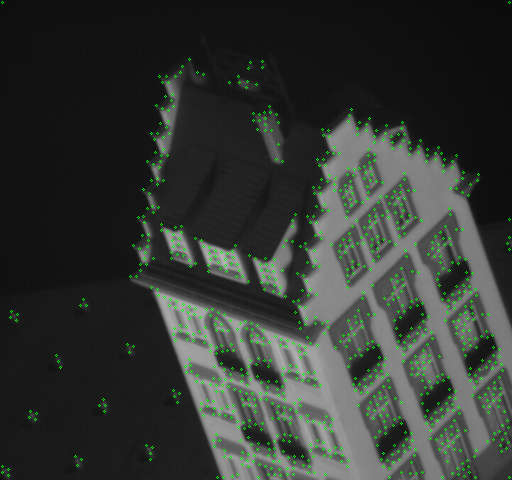

In [44]:
def getKeypoints(img, tau):
  '''
  Detecting keypoints using Harris corner criterion
  img: input image
  tau: threshold 
  
  output: (N,2) array of [x,y] keypoints
  '''
  # YOUR CODE HERE
  #print(input_img.shape)
  grey_img = np.float32(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
  corners = []
  shift = int(5/2)
  y_range = img.shape[0] - shift
  x_range = img.shape[1] - shift

  kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
  kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

  



  dx = linear_filter(grey_img, kernel_x)

  print(dx)

  dy = linear_filter(grey_img, kernel_y)
  
  Ixx = dx**2
  Ixy = dy*dx
  Iyy = dy**2
  
  for y in range(shift, y_range):
      for x in range(shift, x_range):
          start_y = y - shift
          end_y = y + shift + 1
          start_x = x - shift
          end_x = x + shift + 1
          windowIxx = Ixx[start_y : end_y, start_x : end_x]
          windowIxy = Ixy[start_y : end_y, start_x : end_x]
          windowIyy = Iyy[start_y : end_y, start_x : end_x]
          Sxx = windowIxx.sum()
          Sxy = windowIxy.sum()
          Syy = windowIyy.sum()

          det = (Sxx * Syy) - (Sxy**2)
          trace = Sxx + Syy

          r = det - tau*(trace**2)
         
          if r > 60000000:
              corners.append([x, y])
  
  # NMS over a 5x5 neighborhood
  for i in range(len(corners)):
    for j in range(i+1,len(corners)):
      if((corners[i][0] +5) >= corners[j][0] and (corners[i][0] -5) < corners[j][0] and (corners[i][1] +5) >= corners[j][1] and (corners[i][1] -5) < corners[j][1]):
        corners[j][0] =0
        corners[j][1] =0      
  l = len(corners)
  i=0
  while(l):
    if(corners[i][0] == 0):
      corners.pop(i)        
    else:
      i=i+1
    l=l-1
  
  corners = np.asarray(corners)
  print(corners)
  return corners


def linear_filter(img, kernel):

  img_x = img.shape[0]
  img_y = img.shape[1]
  kernel_x, kernel_y = kernel.shape
  kernel_x = int(np.floor(kernel_x/2))
  kernel_y = int(np.floor(kernel_y/2))

  img_padded = np.pad(img, (kernel_x, kernel_y), 'constant', constant_values=0)
  X = img_padded.shape[0] 
  Y = img_padded.shape[1]
  
  conv_output = np.zeros((img_x, img_y))

  for i in range(kernel_x, X-kernel_x):
      for j in range(kernel_y, Y-kernel_y):
          window = img_padded[i-kernel_x:i+kernel_x+1, j-kernel_y:j+kernel_y+1]
          conv_output[i-kernel_x][j-kernel_y] = np.sum(window*kernel)
  
  return conv_output
# compute keypoints in the first sequence
tau = 0.06
key_pts = getKeypoints(im[0], tau)

# add plots for the write-up
# YOUR CODE HERE
temp = im[0]
#cv2_imshow(grey_image_suppressed)
for point in key_pts:
        cv2.circle(temp,tuple(point),1,(0, 255, 0))
cv2_imshow(temp)

### Write-up (10 pts)


*   (5 pts) Explain your implementation of getKeypoints()
*   (5 pts) Display the first frame of the sequence overlaid with the detected keypoints. Ensure that they are clearly visible (plot with `color='g' and linewidths=3`)



**Include your write-up here**


*   After reading in the image in, the first step is to set the image to grayscale. This is done to firstly convert it from a 3 channel to a 1 channel information. Then once that is done, we take 2 linear filters and implement it on the image in order and to normalise the values of the gradients we divide it by its max value. Once the x and the y gradients are found, we need to determine the x^2, y^2 and the xy gradient which are calculated. A threshold value of 60000000 has been taken as values lower than that seem to be over populating similar regions. Then for each pixel we calculate the gradients to find R values. The R values will be an indication of cornerness. This showcases that if a point has a R value greater than a threshold then it is a corner. The final values are then subjected to a non maxima suppression locally so only the max values in the local section are taken and the rest are omitted. This allows us to filter out the final points and therefore finally mark the key tracking points.



## 1.2 Feature Tracking (35 pts)

Apply the Kanade-Lucas-Tomasi tracking procedure to track the keypoints found in part 1.1 (or the given keypoints in the *Data* section) throughout the hotel sequence. 

<img src="https://drive.google.com/uc?id=1dU4p4YcnXoQFnrNvleEty_4tDECkVW9Q" width="500"/>

Some keypoints will move out of the image frame over the course of the sequence. Discard any track if the predicted translation falls outside the image frame.

**Hint:**

*  From the 1st frame to the 2nd frame, use the detected keypoints at the first frame as initialization points. From the 2nd to 3rd frame, use the tracked positions at the 2nd frame as initialization. Note that the tracked keypoints in general are not at integer positions.

*  For each point, use a window size of 15 x 15.

Add codes to **plot** your tracked points overlayed in the **first sequence** and the **last sequence**. They should look similar to the second picture shown in the Overview section. 



### Code (10 pts)

In [45]:
def getNextPoints(x, y, im1, im2, ws):
  '''
  Iterative Lucas-Kanade feature tracking
  x,  y : initialized keypoint position in im2
  ws: patch window size

  output: tracked keypoint positions in im2
  '''
  # YOUR CODE HERE
  x2 = np.copy(x).astype(float)
  y2 = np.copy(y).astype(float)
  im1 = im1.astype(np.float32)
  im2 = im2.astype(np.float32)

  # Gaussian kernel for smoothing
  kernel = np.array([
          [1, 4, 7, 4, 1],
          [4, 16, 26, 16, 4],
          [7, 26, 41, 26, 7],
          [4, 16, 26, 16, 4],
          [1, 4, 7, 4, 1,]], dtype=np.float32) / 273.0

  grey_img_1 = np.float32(cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY))
  grey_img_2 = np.float32(cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY))
  img = linear_filter(grey_img_1, kernel).astype(np.float32)
  Iy, Ix =  np.gradient(img)

  # The given KLT algorithm is implemented
  for i in range(len(x)):
    patch_x = cv2.getRectSubPix(Ix, (15,15), (x[i], y[i]))
    patch_y = cv2.getRectSubPix(Iy, (15,15), (x[i], y[i]))
    A = np.array([[np.sum(patch_x * patch_x), np.sum(patch_x * patch_y)], [np.sum(patch_x * patch_y), np.sum(patch_y * patch_y)]])

    for j in range(25):
      patch_t = cv2.getRectSubPix(grey_img_2, (15,15), (x2[i], y2[i])) - cv2.getRectSubPix(img, (15, 15), (x[i], y[i]))
      B = -1* np.array([[np.sum(patch_x*patch_t)],[np.sum(patch_y*patch_t)]])
      disp = np.matmul(np.linalg.pinv(A), B)

      u = disp[0]
      v = disp[1]

      x2[i] = x2[i] + u 
      y2[i] = y2[i] + v

      # Checking if the norm of (u, v) is leser than the threshold (from the textbook section - 9.1.3 Incremental refinement)
      if np.hypot(u, v) <= 0.01:
        break

  

  return (x2, y2)

# track keypoints across the sequences, getNextPoints() is called inside the trackPoints() function
ws = 7

tracked_pts = trackPoints(pt_x=key_pts[:,0], pt_y=key_pts[:,1], im=im, ws=ws)


(2, 1077, 51)
(2, 51, 1077)
[[  43.            2.            0.         ...   -1.
    -1.          -35.        ]
 [  59.            1.            1.         ...   -4.
     0.          -45.        ]
 [  60.            2.            3.         ...   -5.
     0.          -44.        ]
 ...
 [  85.            3.           16.         ...   -5.
    -6.99999619 -191.00000381]
 [  78.            3.           16.         ...   -3.00000381
    -1.00000381 -190.00000381]
 [  56.            2.           10.         ...   -4.99999619
    -1.00000381 -140.00000763]]
[[  2   2]
 [509   2]
 [189  59]
 ...
 [442 477]
 [475 477]
 [509 477]]
[[  46.            2.            1.         ...   -4.
    -6.          -31.        ]
 [  62.            0.           -1.         ...   -1.
    -8.          -44.        ]
 [  59.           -2.            1.         ...    2.
    -6.          -46.        ]
 ...
 [ 111.           35.99999619   46.         ...   -6.99998856
    -6.99998856 -187.00001144]
 [  97.        

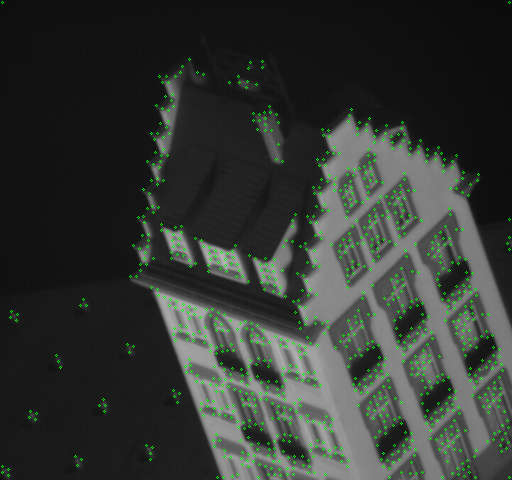

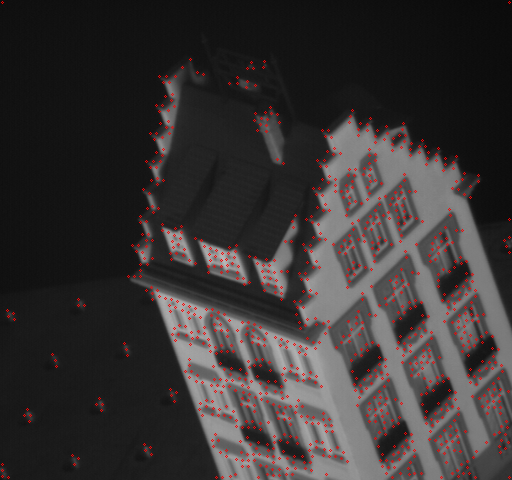

In [46]:
print(np.array(tracked_pts).shape)
rows = np.array(tracked_pts).shape[1]
columns = np.array(tracked_pts).shape[2]

# plot your results
# YOUR CODE HERE
tracked_pts = np.array(tracked_pts).reshape(2,columns,rows)
print(tracked_pts.shape)
im = readImages(folder, 51)
#im0color = np.float32(cv2.cvtColor(im[0], cv2.COLOR_GRAY2BGR))
im0color = im[0]
im1color = im[1]
key_pts_1 = getKeypoints(im[0], tau)
key_pts_2 = getKeypoints(im[1], tau)
for point in key_pts_1:
        cv2.circle(im0color,tuple(point),1,(0, 255, 0))
for point in key_pts_2:
        cv2.circle(im1color,tuple(point),1,(0, 0, 255))
cv2_imshow(im0color)
cv2_imshow(im1color)

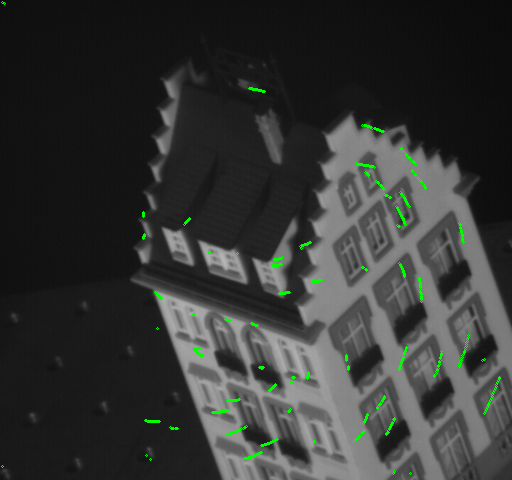

In [47]:
x_points = tracked_pts[0]
y_points = tracked_pts[1]

im = readImages(folder, 51)
random_20 = np.random.randint(0,high = 1077, size = 20)
im0color = im[0]
for i in range(len(random_20)):
  for j in range(51):
    cv2.circle(im0color,(round(x_points[j][i]), round(y_points[j][i])),1,(0, 255, 0))
cv2_imshow(im0color)

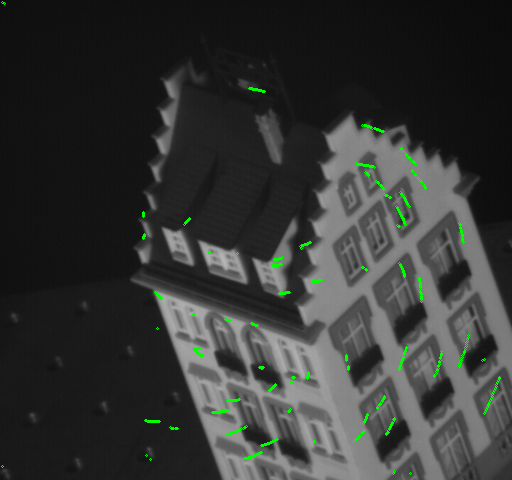

In [48]:
im = readImages(folder, 51)
random_20 = np.random.randint(0,high = 1077, size = 20)
im0color = im[0]
for i in range(len(random_20)):
  for j in range(51):
    cv2.circle(im0color,(round(x_points[j][i]), round(y_points[j][i])),1,(0, 255, 0))
cv2_imshow(im0color)

### Write-up (25 pts)

*   (5 pts) For all the keypoints, display (1) the keypoints at the first frame (as green) and (2) the tracked keypoints at the second frame (as red) on the first frame of the sequence.
*   (10 pts) For 20 random keypoints, draw the 2D path over the sequence of frames. That is, plot the progression of image coordinates for each of the 20 keypoints. Plot each of the paths on the same figure, overlaid on the first frame of the sequence.
*   (10 pts) On top of the first frame, plot the points which have moved out of frame at some point along the sequence.





All Images created.

# Part 2: Shape Alignment (30 Points)

## Overview
In this problem, you will write a function that aligns two sets of points using global image transformation (similarity, affine, or perspective) and returns $T$  where $T$ is a transformation that maps non-zero points in $im1$ to non-zero points in $im2$. You may choose the alignment algorithm and the type of (global) transformation (e.g., rigid Euclidean, affine, perspective).


<img src="https://drive.google.com/uc?id=1PnWIy9ZdP9SGkmGNtFCJ-JzKLwmW-qaN" width="1000"/>

Test your code on the 25 image pairs provided in the supplementary material. We have included functions 
**(will check) evalAlignmentAll and displayAlignment to help with evaluation and display**.




## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [49]:
# Download Data -- run this cell only one time per runtime
!gdown 18Px9uQyY1fGGyEAQhzt3h4yDQonU_Sgm
!unzip "/content/part2_images.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=18Px9uQyY1fGGyEAQhzt3h4yDQonU_Sgm
To: /content/part2_images.zip
100% 78.4k/78.4k [00:00<00:00, 51.5MB/s]
Archive:  /content/part2_images.zip
replace /content/part2_images/Bone_1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: /content/part2_images/Bone_1.png  
replace /content/part2_images/elephant_1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/part2_images/elephant_1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y a
 extracting: /content/part2_images/elephant_1.png  
replace /content/part2_images/brick_2.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: /content/part2_images/brick_2.png  
replace /content/part2_images/Heart_2.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: /content/part2_images/Heart_2.png  
replace /content/part2_images/Bone_2.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/part2_images/elephant_2.png? [y]es, [n]o, [A]ll, [N]one, [r

## Helper Functions

In [50]:
def evalAlignment(aligned1, im2):
  '''
  Computes the error of the aligned image (aligned1) and im2, as the
  average of the average minimum distance of a point in aligned1 to a point in im2
  and the average minimum distance of a point in im2 to aligned1.
  '''
  d2 = ndimage.distance_transform_edt(1-im2) #distance transform
  err1 = np.mean(np.mean(d2[aligned1 > 0]))
  d1 = ndimage.distance_transform_edt(1-aligned1);
  err2 = np.mean(np.mean(d2[im2 > 0]))
  err = (err1+err2)/2;
  return err

def displayAlignment(im1, im2, aligned1, thick=False):
  '''
  Displays the alignment of im1 to im2
     im1: first input image to alignment algorithm (im1(y, x)=1 if (y, x) 
      is an original point in the first image)
     im2: second input image to alignment algorithm
     aligned1: new1(y, x) = 1 iff (y, x) is a rounded transformed point from the first time 
     thick: true if a line should be thickened for display
  ''' 
  im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
  im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
  
  if thick:
    # for thick lines (looks better for final display)
    dispim = np.concatenate((cv2.dilate(im1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(aligned1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(im2.astype('uint8'), np.ones((3,3), np.uint8), iterations=1)), axis=-1)
  else:
    # for thin lines (faster)
    dispim = np.concatenate((im1, aligned1, im2), axis = -1)
    cv2_imshow(dispim)
  return dispim
  

## Code (15 pts)

In [51]:
def align_shape(im1, im2):
  '''
  im1: input edge image 1
  im2: input edge image 2

  Output: transformation T [3] x [3]
  '''
  '''
  im1: input edge image 1
  im2: input edge image 2

  Output: transformation T [3] x [3]
  '''
  # YOUR CODE HERE

  im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
  im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
  
  
  edp_1 = np.argwhere(im1 == 255)
  edp_2 = np.argwhere(im2 == 255)
  
  # Find mean of edge points
  me_1 = np.mean(edp_1, axis=0)
  me_2 = np.mean(edp_2, axis=0)

  # Convert to homogeneous coordinates 
  edp_1_homo = np.ones((edp_1.shape[0], 3))
  print(edp_1_homo.shape)
  edp_1_homo[:, 0:2] = edp_1
  
  edp_2_homo = np.ones((edp_2.shape[0], 3))
  edp_2_homo[:, 0:2] = edp_2
  
  # Find variance of edge points
  ve_1 = np.var(edp_1, axis=0)
  ve_2 = np.var(edp_2, axis=0)
  
  # Initialize transformation matrix
  i_t_m = np.matrix([[np.sqrt(ve_2[0]/ve_1[0]), 0, me_2[0] - me_1[0]], [0, np.sqrt(
      ve_2[1]/ve_1[1]), me_2[1] - me_1[1]]])

  # Find Transformed points
  tp = np.matmul(i_t_m, edp_1_homo.T).T
  tp = np.round(tp).astype(int)

  tp_homo = np.ones((tp.shape[0], 3))
  tp_homo[:, 0:2] = tp

  # Find Cooresponding points
  np_1 = tp.copy()
  np_2 = edp_2.copy()
  corresponding_point = []

  for point_1 in np_1:
      minIndex = np.argmin(np.linalg.norm(np_2 - point_1, axis=1))
      minPoint = np_2[minIndex]
      corresponding_point.append(minPoint)

  corresponding_point = np.array(corresponding_point)

  # Compute Affine transformation matrix
  A = np.zeros((2*np_1.shape[0], 6))
  B = np.zeros((2*np_1.shape[0], 1))

  for i in range(np_1.shape[0]):
      A[2*i, 0:2] = np_1[i]
      A[2*i, 4] = 1
      A[2*i+1, 2:4] = np_1[i]
      A[2*i+1, 5] = 1

      B[2*i] = corresponding_point[i, 0]
      B[2*i+1] = corresponding_point[i, 1]

  x = np.linalg.lstsq(A, B, rcond=None)[0]

  T = np.matrix([[x[0, 0], x[1, 0], x[4, 0]], [
                x[2, 0], x[3, 0], x[5, 0]], [0, 0, 1]])

  T = np.matmul(i_t_m, T)

  T = np.vstack((T, np.array([0, 0, 1])))

  tp_1 = np.matmul(T, edp_1_homo.T).T
  tp_1 = np.round(tp_1).astype(int)
  transformed_Image = np.zeros(im1.shape)
    
  for i in range(tp_1.shape[0]):
    if tp_1[i, 0] < im1.shape[0] and tp_1[i, 1] < im1.shape[1]:
        transformed_Image[tp_1[i, 0],
                            tp_1[i, 1]] = 255

  
  return T, transformed_Image


/content/part2_images/apple_1.png
/content/part2_images/apple_2.png
(256, 256, 3)
(256, 256, 3)
(700, 3)
for apple error value: 180.633095


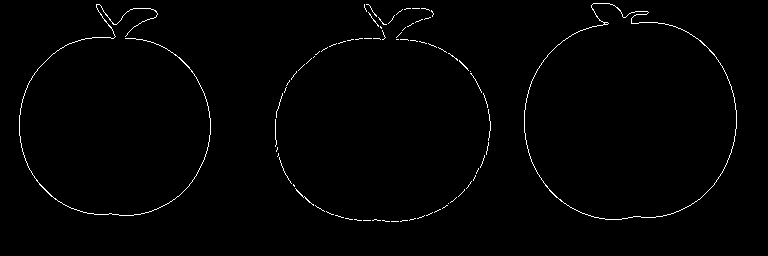

Time needed: 0.093782 secs
/content/part2_images/bat_1.png
/content/part2_images/bat_2.png
(594, 634, 3)
(594, 634, 3)
(1889, 3)
for bat error value: 407.753391


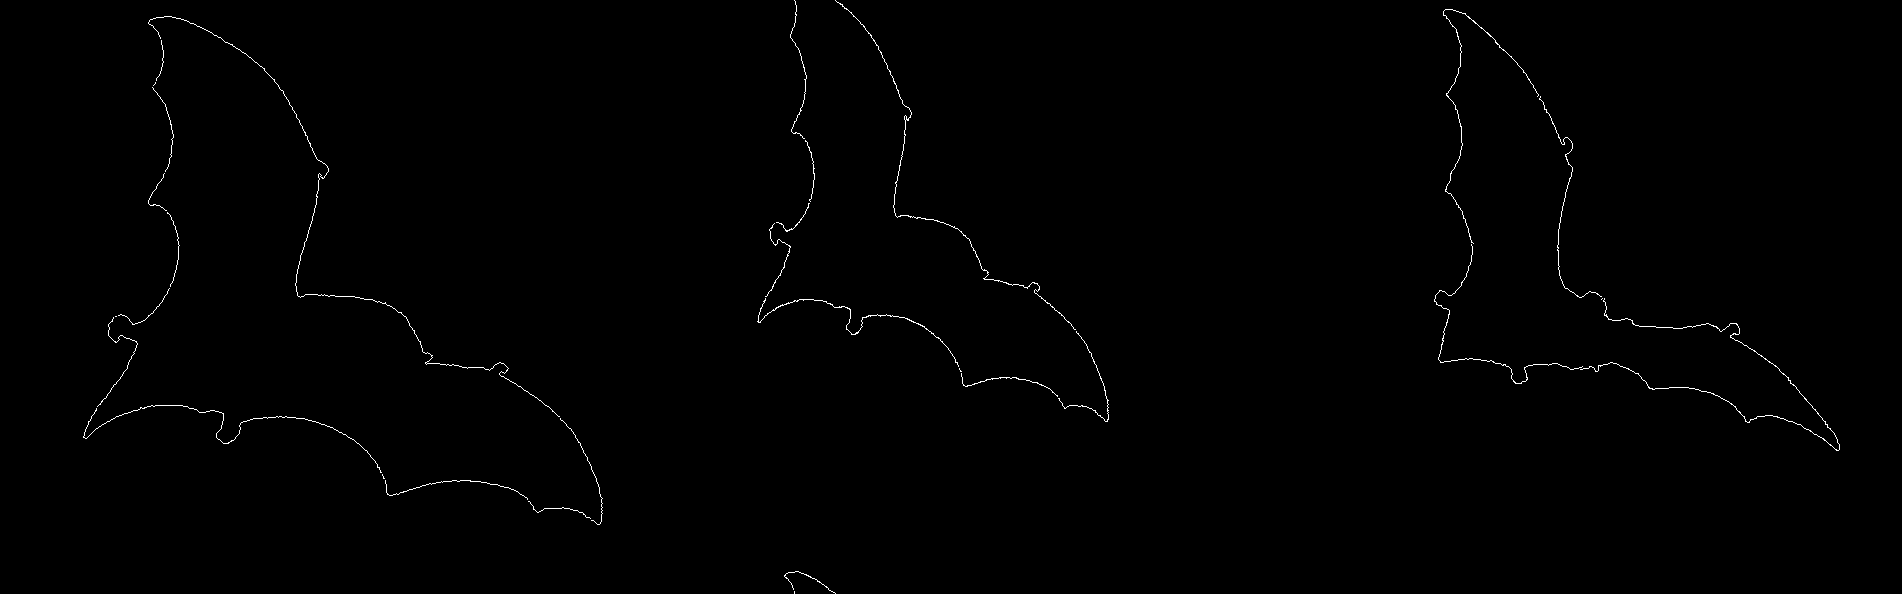

Time needed: 0.429550 secs
/content/part2_images/bell_1.png
/content/part2_images/bell_2.png
(233, 206, 3)
(233, 206, 3)
(503, 3)
for bell error value: 179.399244


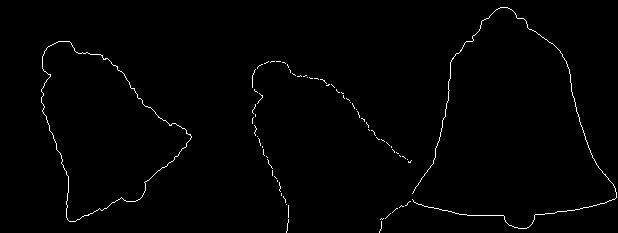

Time needed: 0.064561 secs
/content/part2_images/bird_1.png
/content/part2_images/bird_2.png
(331, 291, 3)
(331, 291, 3)
(1129, 3)
for bird error value: 239.201504


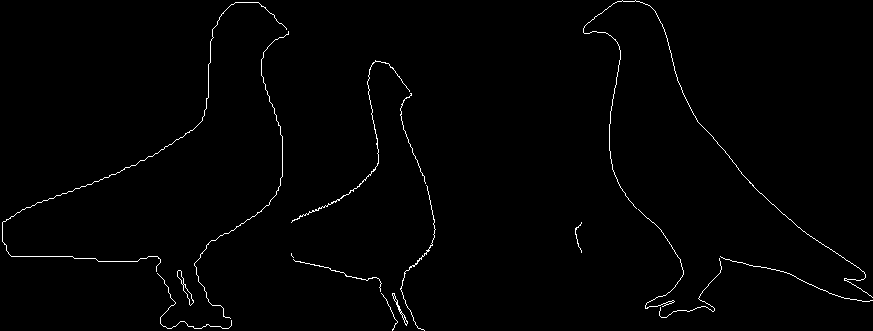

Time needed: 0.164369 secs
/content/part2_images/Bone_1.png
/content/part2_images/Bone_2.png
(439, 357, 3)
(439, 357, 3)
(1143, 3)
for Bone error value: 325.314324


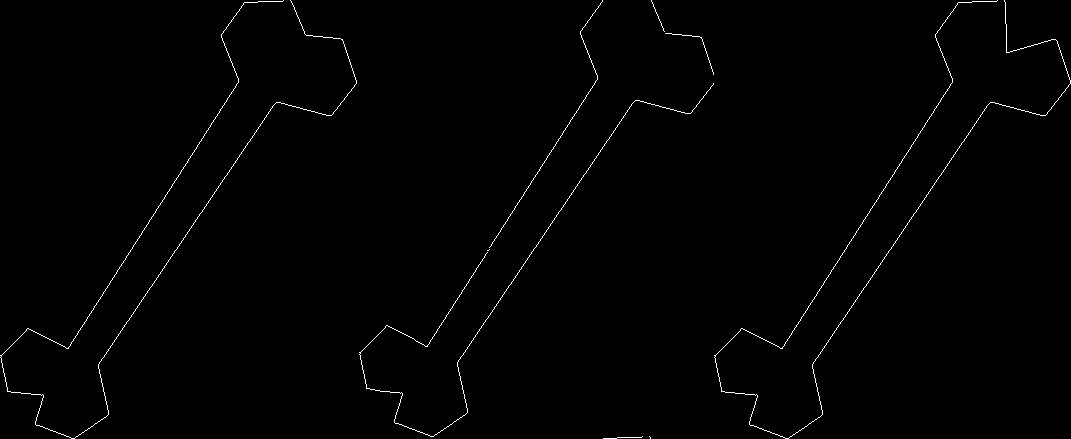

Time needed: 0.210192 secs
/content/part2_images/bottle_1.png
/content/part2_images/bottle_2.png
(288, 352, 3)
(288, 352, 3)
(330, 3)
for bottle error value: 264.581941


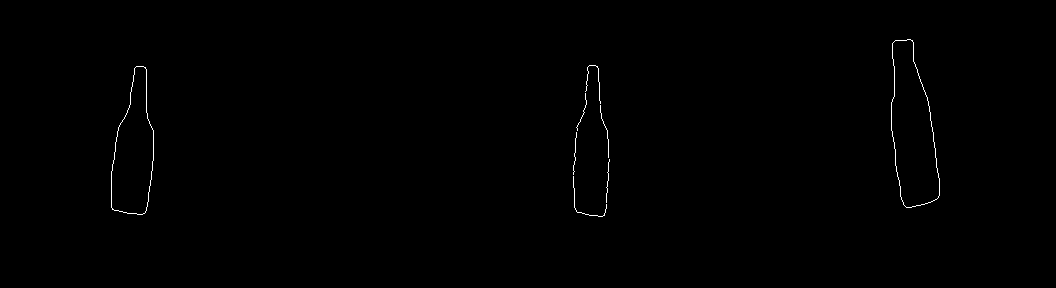

Time needed: 0.065992 secs
/content/part2_images/brick_1.png
/content/part2_images/brick_2.png
(288, 352, 3)
(288, 352, 3)
(519, 3)
for brick error value: 312.875844


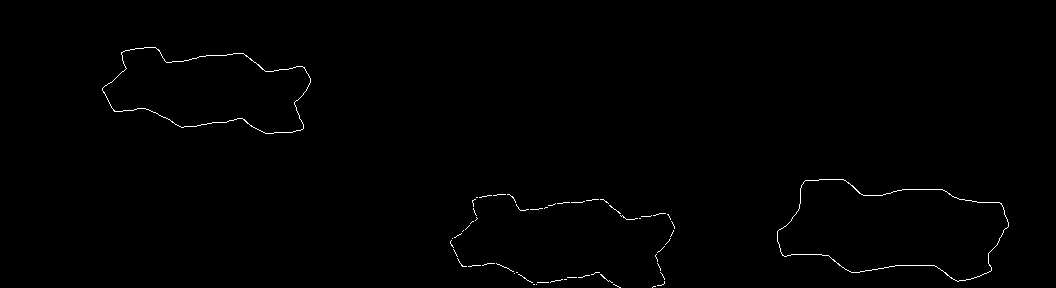

Time needed: 0.074144 secs
/content/part2_images/butterfly_1.png
/content/part2_images/butterfly_2.png
(315, 327, 3)
(315, 327, 3)
(1256, 3)
for butterfly error value: 186.839292


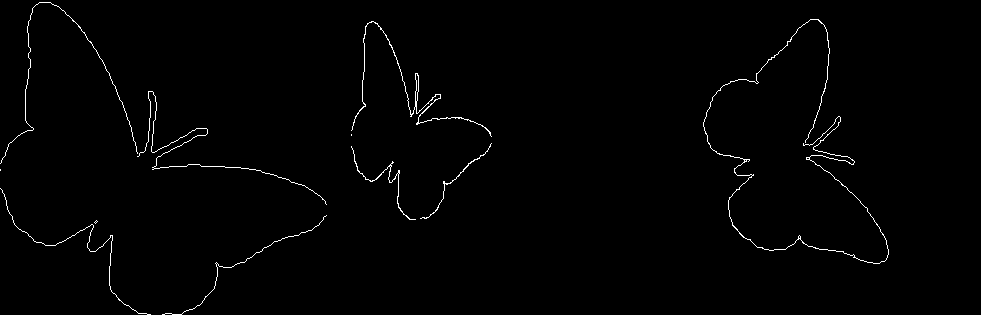

Time needed: 0.170651 secs
/content/part2_images/camel_1.png
/content/part2_images/camel_2.png
(339, 372, 3)
(339, 372, 3)
(1306, 3)
for camel error value: 280.788122


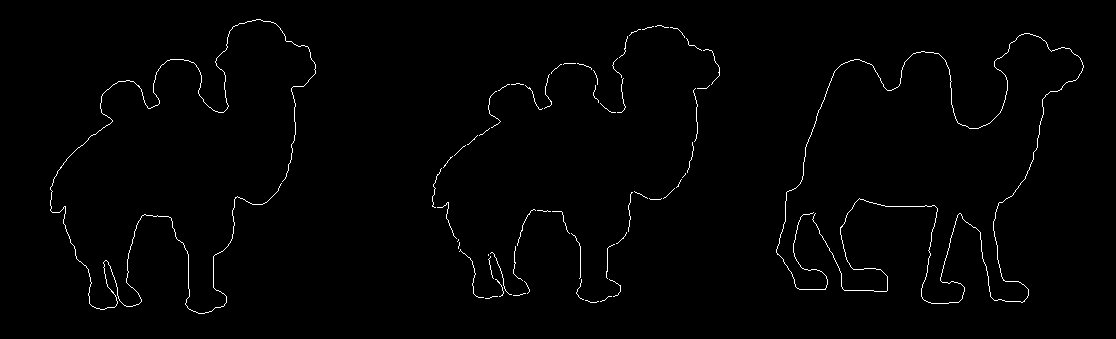

Time needed: 0.235008 secs
/content/part2_images/car_1.png
/content/part2_images/car_2.png
(288, 352, 3)
(288, 352, 3)
(451, 3)
for car error value: 256.311241


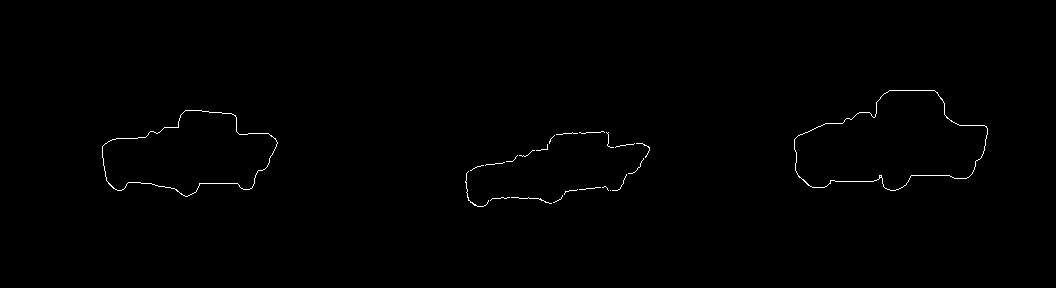

Time needed: 0.080518 secs
/content/part2_images/carriage_1.png
/content/part2_images/carriage_2.png
(288, 352, 3)
(288, 352, 3)
(739, 3)
for carriage error value: 281.465383


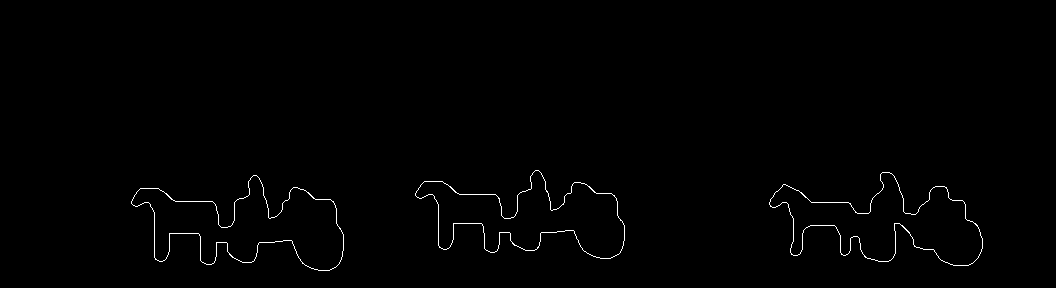

Time needed: 0.100117 secs
/content/part2_images/cattle_1.png
/content/part2_images/cattle_2.png
(531, 640, 3)
(531, 640, 3)
(3174, 3)
for cattle error value: 339.611352


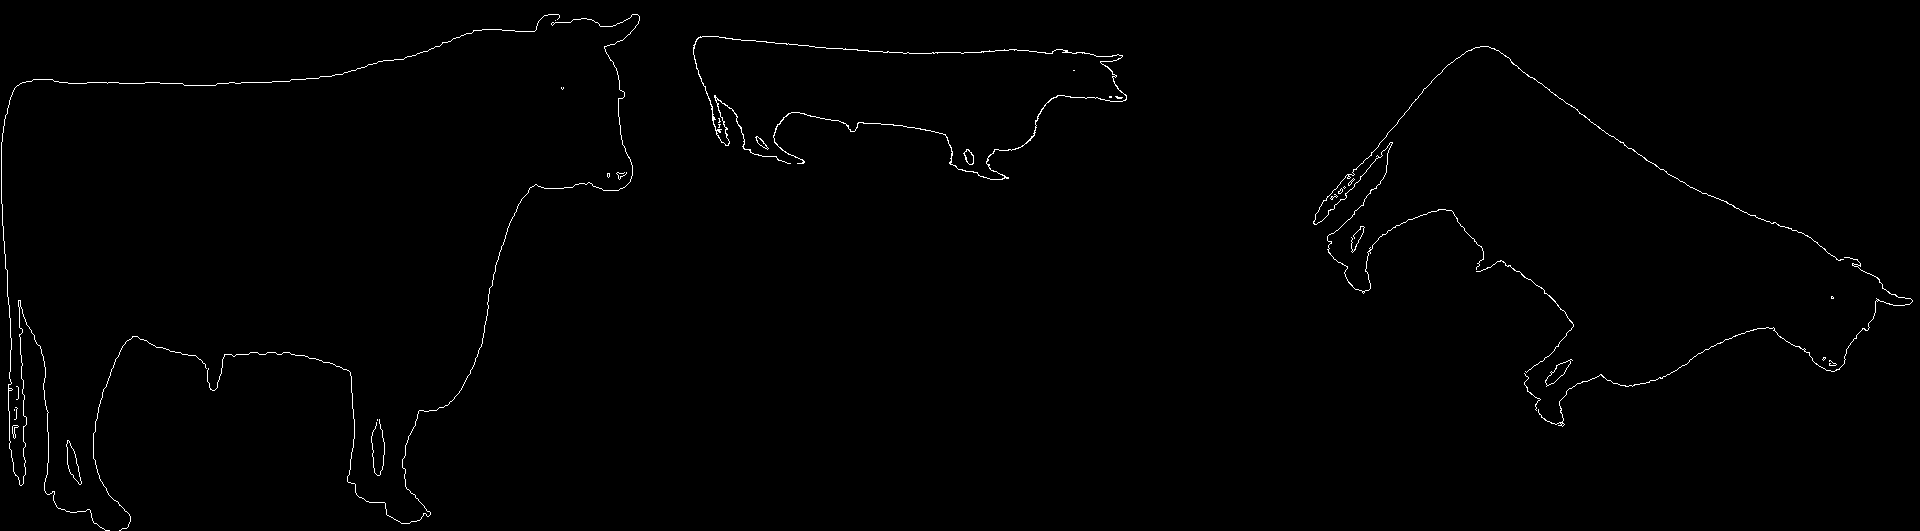

Time needed: 0.543996 secs
/content/part2_images/cellular_phone_1.png
/content/part2_images/cellular_phone_2.png
(180, 443, 3)
(180, 443, 3)
(938, 3)
for cellular_phone error value: 263.291591


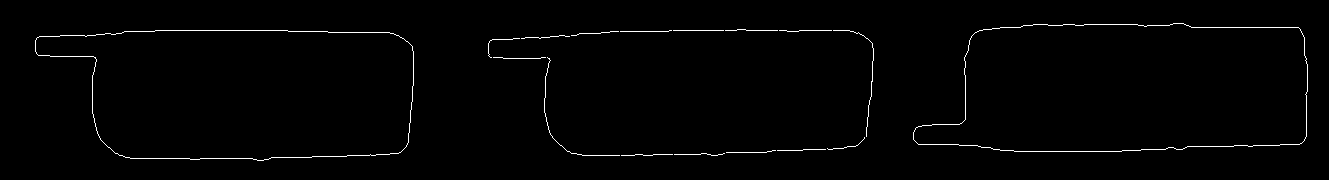

Time needed: 0.126816 secs
/content/part2_images/chicken_1.png
/content/part2_images/chicken_2.png
(203, 213, 3)
(203, 213, 3)
(685, 3)
for chicken error value: 146.179475


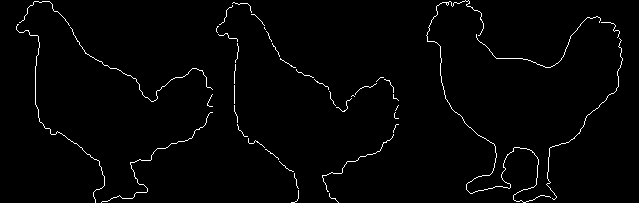

Time needed: 0.094868 secs
/content/part2_images/children_1.png
/content/part2_images/children_2.png
(240, 352, 3)
(240, 352, 3)
(400, 3)
for children error value: 156.090485


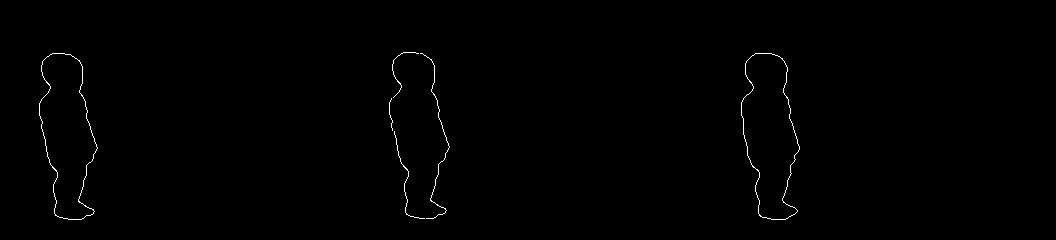

Time needed: 0.057592 secs
/content/part2_images/device7_1.png
/content/part2_images/device7_2.png
(512, 512, 3)
(512, 512, 3)
(3769, 3)
for device7 error value: 383.970790


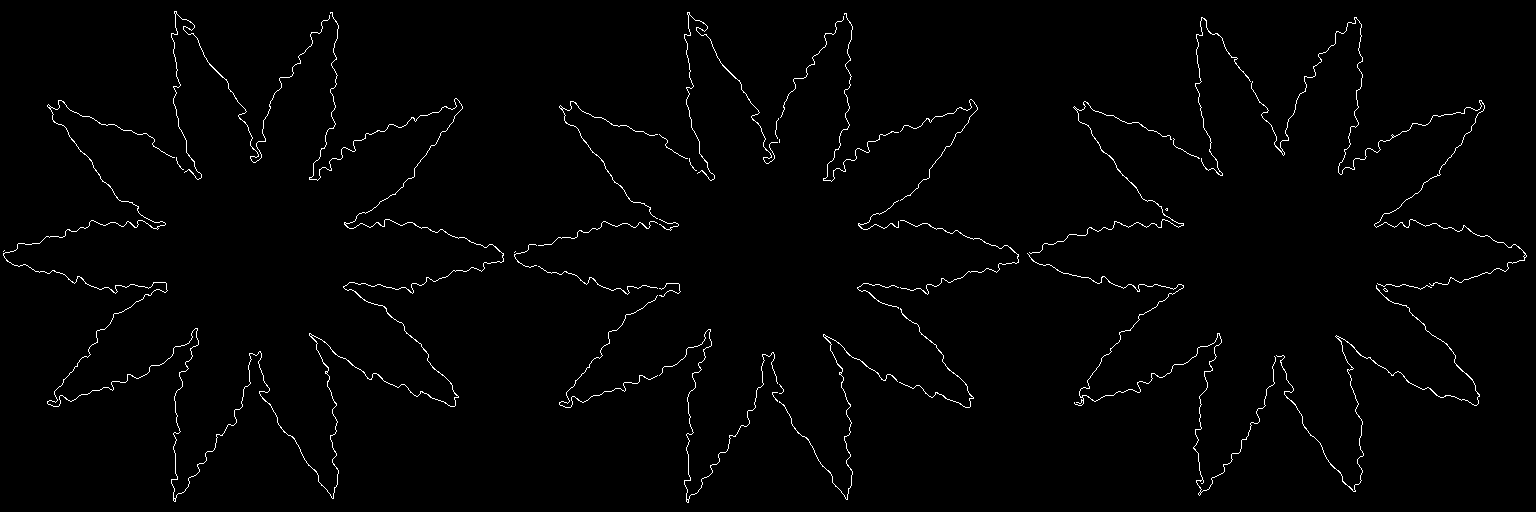

Time needed: 0.784671 secs
/content/part2_images/dog_1.png
/content/part2_images/dog_2.png
(415, 465, 3)
(415, 465, 3)
(2351, 3)
for dog error value: 347.217805


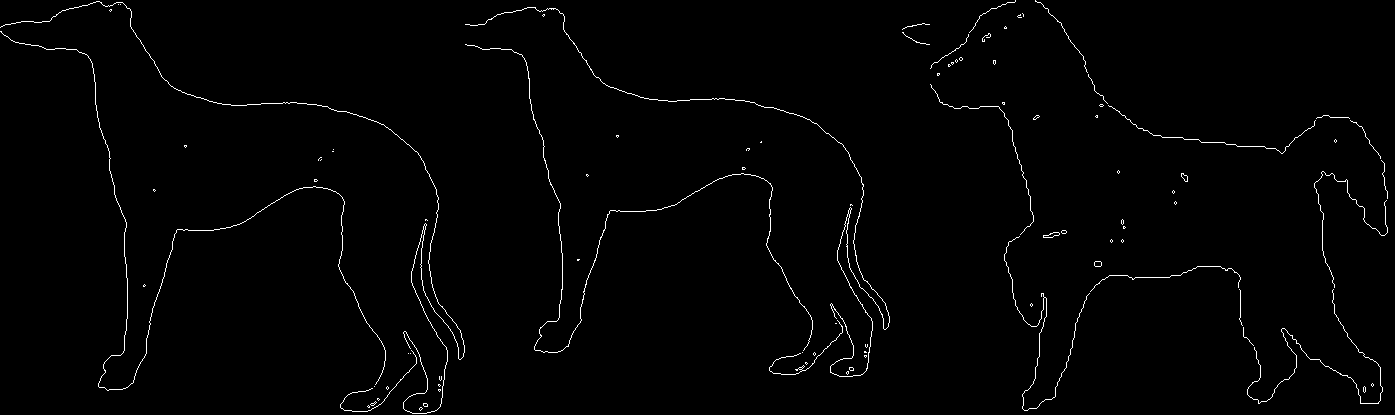

Time needed: 0.415281 secs
/content/part2_images/elephant_1.png
/content/part2_images/elephant_2.png
(665, 721, 3)
(665, 721, 3)
(3316, 3)
for elephant error value: 567.443193


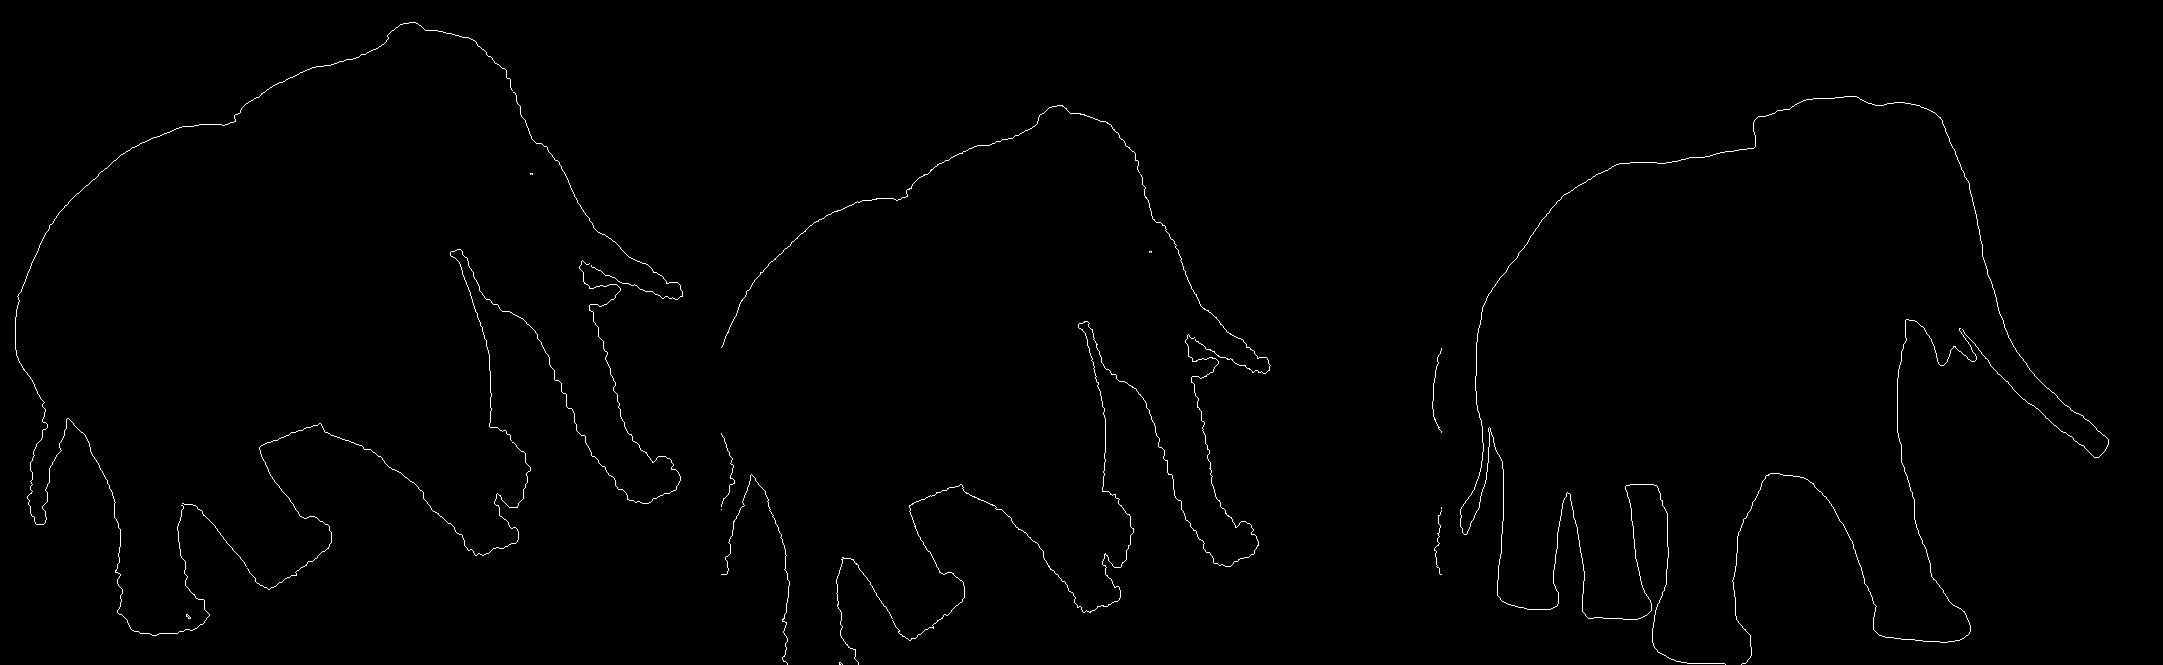

Time needed: 0.764745 secs
/content/part2_images/face_1.png
/content/part2_images/face_2.png
(337, 269, 3)
(337, 269, 3)
(744, 3)
for face error value: 233.524268


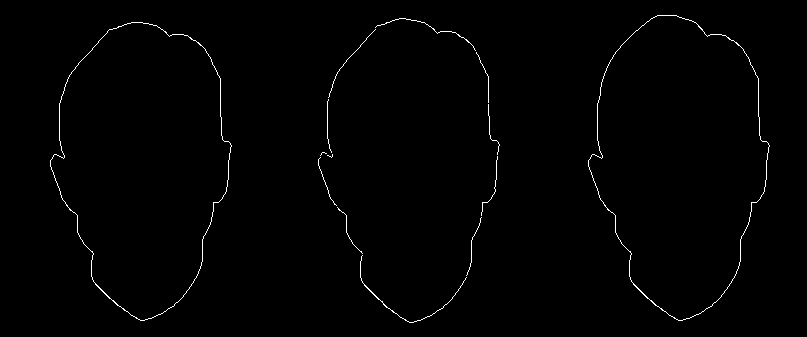

Time needed: 0.095109 secs
/content/part2_images/fork_1.png
/content/part2_images/fork_2.png
(480, 640, 3)
(480, 640, 3)
(1944, 3)
for fork error value: 357.375480


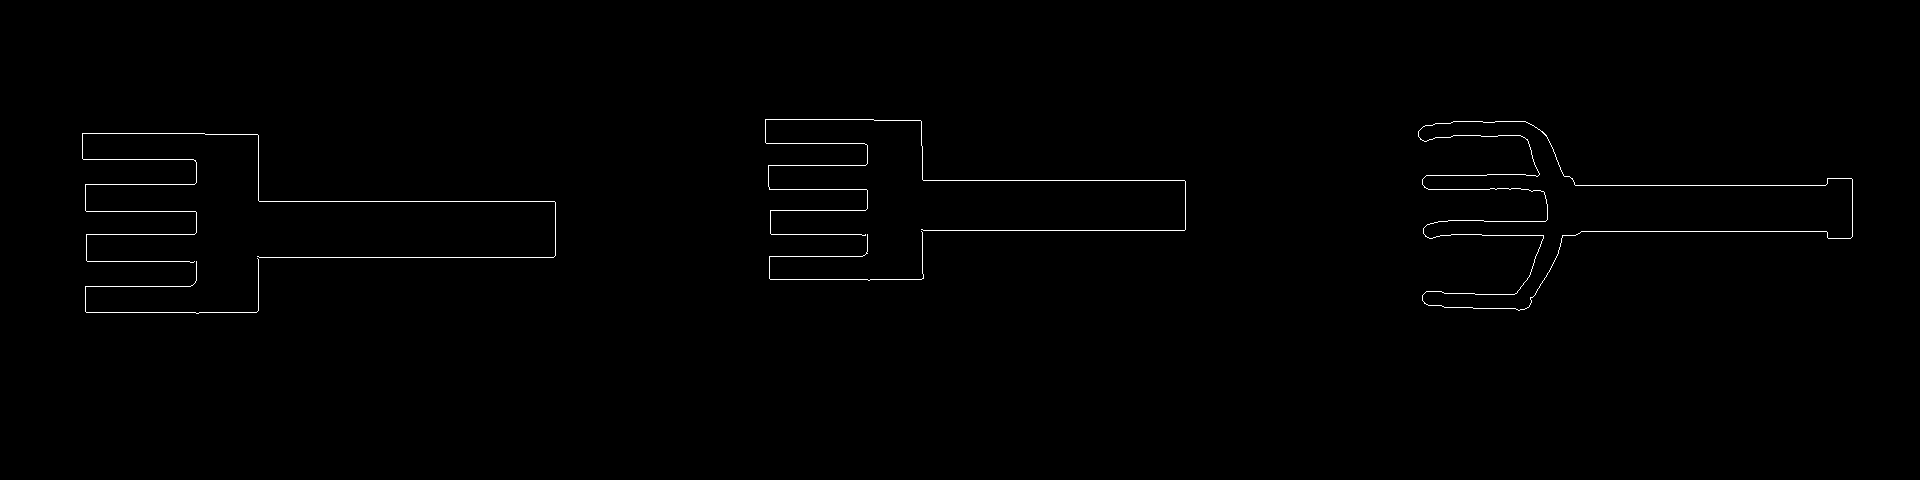

Time needed: 0.359756 secs
/content/part2_images/hammer_1.png
/content/part2_images/hammer_2.png
(256, 256, 3)
(256, 256, 3)
(613, 3)
for hammer error value: nan


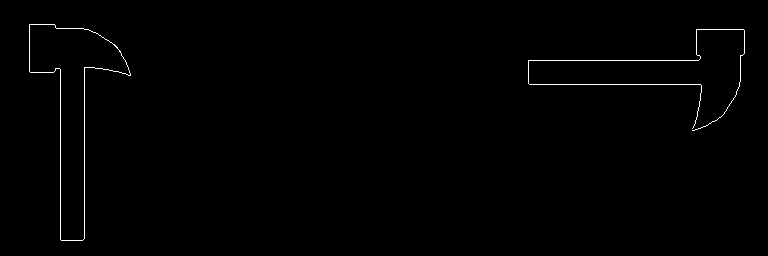

Time needed: 0.064465 secs
/content/part2_images/Heart_1.png
/content/part2_images/Heart_2.png
(384, 464, 3)
(384, 464, 3)
(1329, 3)
for Heart error value: 313.534365


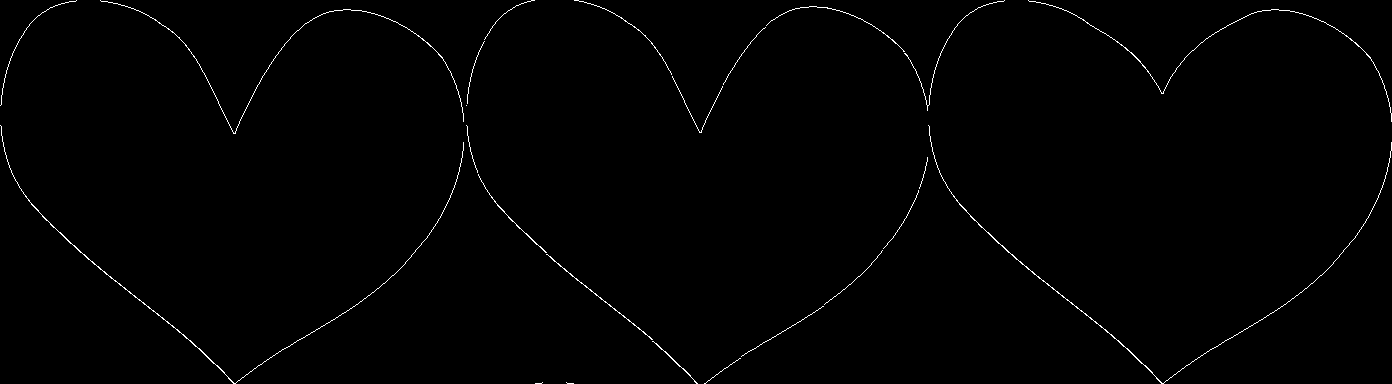

Time needed: 0.209362 secs
/content/part2_images/horse_1.png
/content/part2_images/horse_2.png
(547, 643, 3)
(547, 643, 3)
(3217, 3)
for horse error value: 493.639468


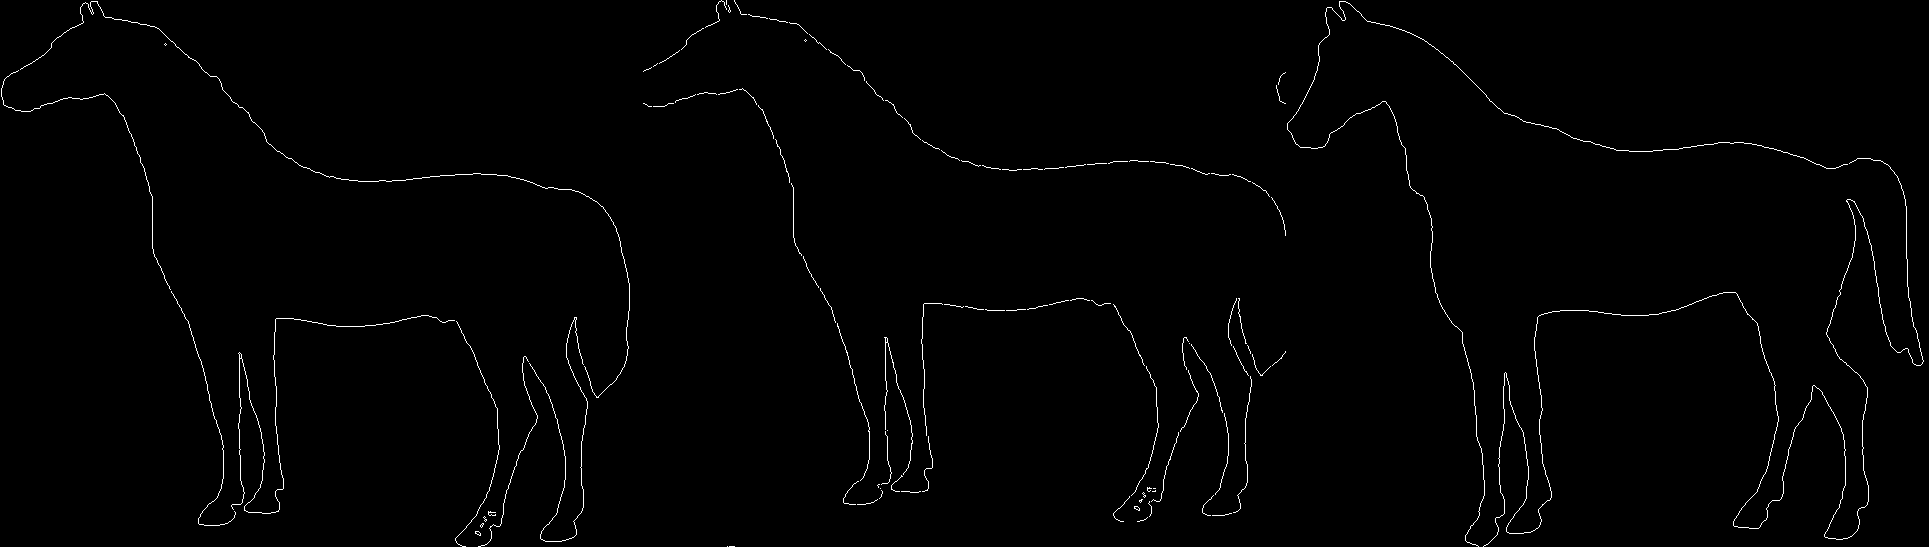

Time needed: 0.696623 secs
/content/part2_images/jar_1.png
/content/part2_images/jar_2.png
(512, 512, 3)
(512, 512, 3)
(1905, 3)
for jar error value: 375.042709


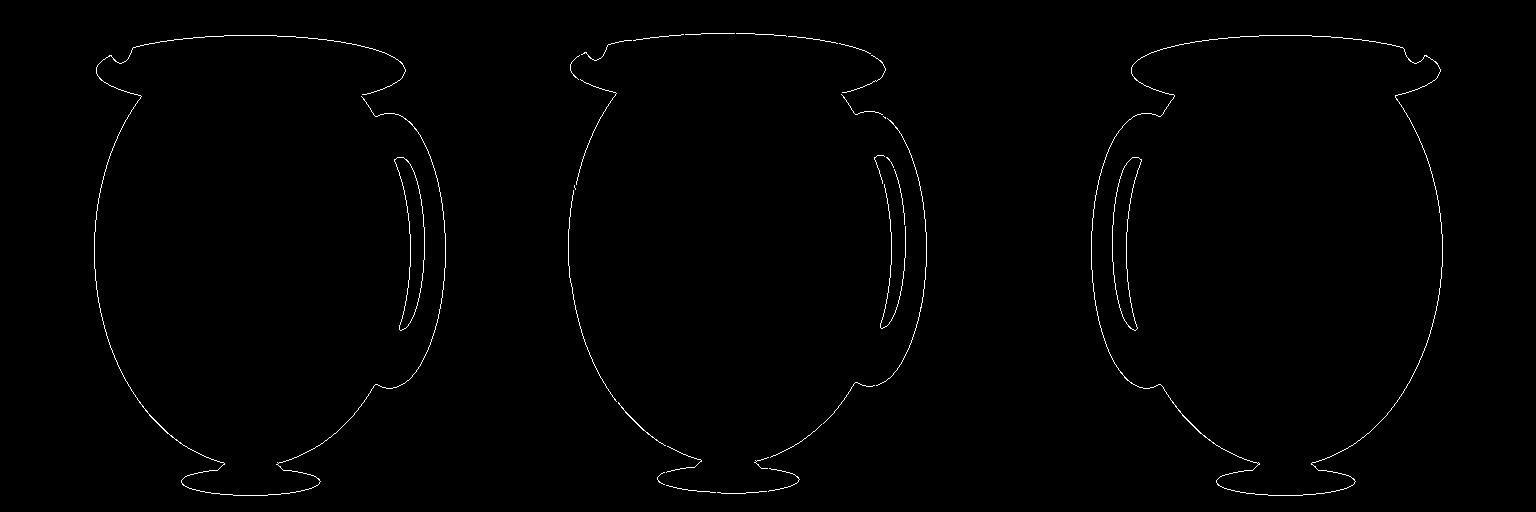

Time needed: 0.361230 secs
/content/part2_images/turtle_1.png
/content/part2_images/turtle_2.png
(334, 353, 3)
(334, 353, 3)
(963, 3)
for turtle error value: 249.427468


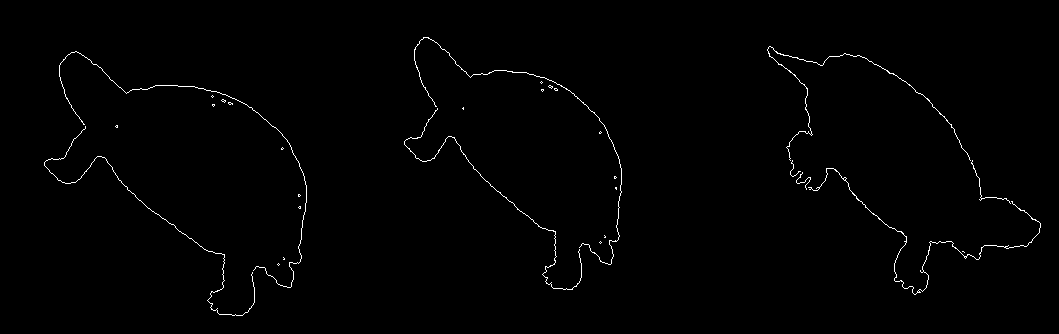

Time needed: 0.140397 secs


In [66]:
imgPath = '/content/part2_images/';

objList = ['apple', 'bat', 'bell', 'bird', 'Bone', 'bottle', 'brick', \
    'butterfly', 'camel', 'car', 'carriage', 'cattle', 'cellular_phone', \
    'chicken', 'children', 'device7', 'dog', 'elephant', 'face', 'fork', 'hammer', \
    'Heart', 'horse', 'jar', 'turtle']

numObj = len(objList)

# Add code to run align_shape() and display the results and the errors
# YOUR CODE HERE
import time
for i in range(numObj):
  start_time = time.time()
  file_1 = imgPath + objList[i] + '_1.png'
  file_2 = imgPath + objList[i] + '_2.png'
  print(file_1)
  print(file_2)
  img1 = cv2.imread(file_1)
  img2 = cv2.imread(file_2)
  print(img1.shape)
  print(img2.shape)
  tm, tm_I = align_shape(img1, img2)
  acc = evalAlignment(tm_I, img2)
  print('for %s error value: %2f' %(objList[i], acc ))
  displayAlignment(img1, img2, tm_I, thick=False)
  end = time.time()
  print('Time needed: %2f secs'%(end-start_time))

## Write-up (15 pt)

1. (5 pts) Give a brief explanation of your algorithm, initialization, and model of the transformation.

2. (10 pts) For each result, give:
  1.   The alignment display
  2.   The final error
  3.   The runtime






**Include your write-up here**

1.   For this problem since there are a number of transformations that the images goes through, the affine transformation is chosen. 
The image is first converted into binary and then the edge values are identified. In binary, the values are between 0 and 255 where 0 indicates 0 intensity and is black and the 255 indicates the high intensity points at 255.
The mean point of the edges are then calculated and converted to homogeneous coordinates. The homogeneous or the projected coordinates are taken from the img2 to showcase the final location of the image and the points. 
Once the points in image 1 are mapped to image 2 then in that scenario the affine transformation is done. The affine transformation will provide the final transformation matrix which when implemented on the original image will provide the transformed image. Affine transformation takes into account 4 different types of movement which is why that is the chosen transformation in this case. There can be multiple values that can satisfy the transformation matrix but to choose the one with the best set values, the least squares is taken as a metric and solved and the matrix with the least squares values is chosen. Once the transformed matrix is formed, the transformation matrix is multiplied with the original image matrix to find the final values of the transformed image which can then be compared with the original image 2.



# Part 3: Object Instance Recognition (20 points)

## Overview
This problem explores the Lowe-style object instance recognition.

Implement the nearest neighbor distance ratio test using the pre-computed SIFT features SIFT_features.mat provided in the supplementary material. The Frame1, Frame2 indicate the 2D position, scales, and the orientation of the descriptors and Descriptor1, Descriptor2 are the correspondin 128-D SIFT features. Display the matches like this:

<img src="https://drive.google.com/uc?id=1mULTvHYeP5uj_vi7nwWThBHkDbv1eSue" width="1000"/>



## Data

In [53]:
# Download Data -- run this cell only one time per runtime
!gdown 10ByzpFbB-z178VGjwmCwc95wInD8vpNM # SIFT Features
!gdown 1KLWGMtDEMNNrmzd3Qezrs2-NQR52OfoU # Stop sign image 1
!gdown 13y-o1vdGN6CqqPuUcgU7pIxODTxrYS7J # Stop sign image 1

Downloading...
From: https://drive.google.com/uc?id=10ByzpFbB-z178VGjwmCwc95wInD8vpNM
To: /content/SIFT_features.mat
100% 347k/347k [00:00<00:00, 107MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KLWGMtDEMNNrmzd3Qezrs2-NQR52OfoU
To: /content/stop1.jpg
100% 15.6k/15.6k [00:00<00:00, 21.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=13y-o1vdGN6CqqPuUcgU7pIxODTxrYS7J
To: /content/stop2.jpg
100% 224k/224k [00:00<00:00, 89.6MB/s]


## Code (10 pts)

In [54]:
img1 = cv2.imread('/content/stop1.jpg')
img2 = cv2.imread('/content/stop2.jpg')

## inside the sift are:
## Descriptor1, Descriptor2: SIFT features from image 1 and image 2
## Frame1, Frame2: position, scale, rotation of keypoints
data = loadmat('/content/SIFT_features.mat')
Frame1 = data['Frame1']
Descriptor1 = data['Descriptor1']
Frame2 = data['Frame2']
Descriptor2 = data['Descriptor2']

# YOUR CODE HERE

## matches: a 2 x N array of indices that indicates which keypoints from image
## 1 match which points in image 2
nearest_1 = []
nearest_2 = []
for i in range(len(Descriptor1)):
  #print(i)
  for j in range(len(Descriptor1[i])):
    near_1 = 99999
    near_2 = 99999
    #near_1 to find the closes neighbor and near_2 to find the second closest neighbour
    near1_x = 0
    near2_x = 0
    near1_y = 0
    near2_y = 0
    for k in range(50):
      for l in range(50):
        dist = abs(Descriptor1[i][j] - Descriptor2[k][l])
        if dist<near_1:
          near_1 = dist
  
          near1_x = k
          near1_y = l
        if (dist>near_1) & (dist<near_2):
           near_2 = dist
           near2_x = k
           near2_y = l
    nearest_1.append((near1_x, near1_y, near_1))
    nearest_2.append((near2_x, near2_y, near_2))





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in ubyte_scalars


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in ubyte_scalars
  # This is added back by InteractiveShellApp.init_path()


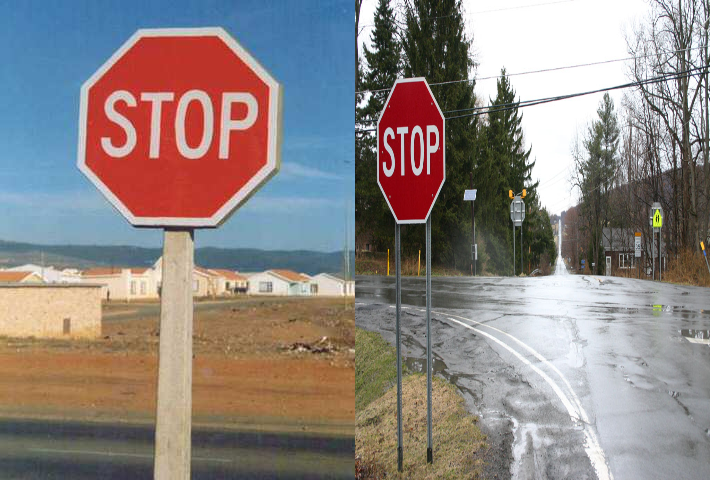

In [55]:
img1 = cv2.imread('/content/stop1.jpg')
img2 = cv2.imread('/content/stop2.jpg')
# using distance thresholding
chosen_x1 = []
chosen_x2 = []
chosen_y1 = []
chosen_y2 = []
for i in range(len(nearest_1)):
  temp_dist1 = nearest_1[i][2]
  temp_dist2 = nearest_1[i][2]
  dist = nearest_1[i][2]/nearest_1[i][2]
  if dist >350:
    chosen_x1.append(nearest_1[i][0]+140)
    chosen_x2.append(nearest_2[i][0] + 370)
    chosen_y1.append(nearest_1[i][1] +90)
    chosen_y2.append(nearest_2[i][1]+ 130)

img2 = cv2.resize(img2, (355,480))
numpy_horizontal_concat = np.concatenate((img1, img2), axis=1)
for i in range(len(chosen_x1)):
  cv2.line(numpy_horizontal_concat,(chosen_x1[i],chosen_y1[i]), (chosen_x2[i],chosen_y2[i]), (0,255,0), thickness = 3 )
cv2_imshow(numpy_horizontal_concat)

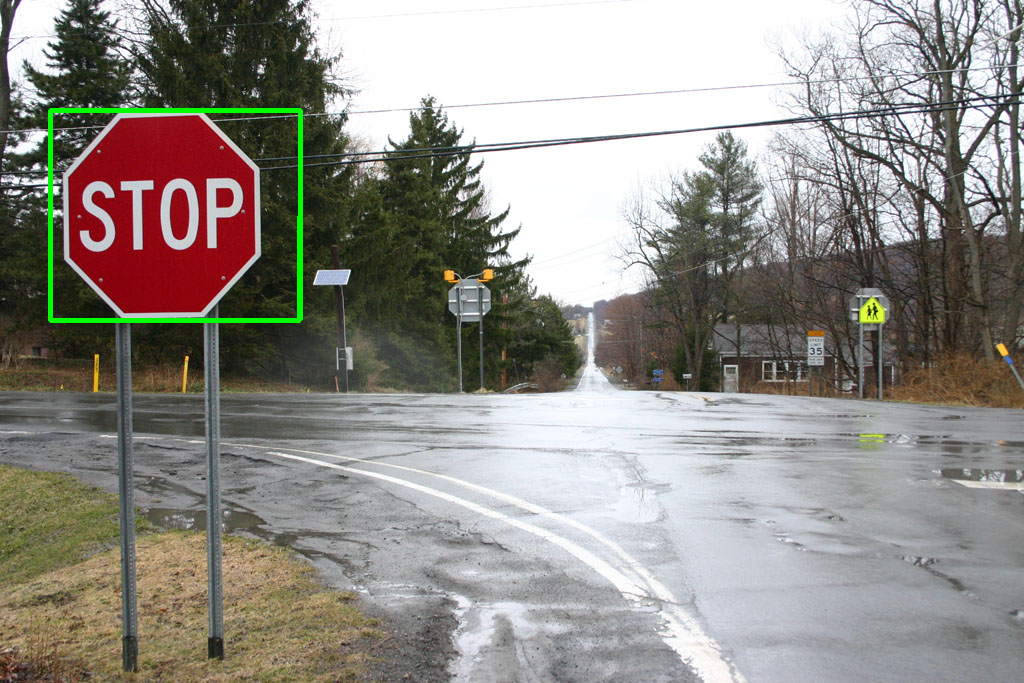

In [56]:
img2 = cv2.imread('/content/stop2.jpg')
starting_point = [50,110]
final_points = []
for i in range(250):
  final_points.append((starting_point[0]+i, starting_point[1]))
for i in range(210):
  final_points.append((starting_point[0], starting_point[1]+i))
for i in range(250):
  final_points.append((starting_point[0]+i, starting_point[1]+210))
for i in range(210):
  final_points.append((starting_point[0]+250, starting_point[1]+i))
for i in range(1,len(final_points)):
  cv2.line(img2,(final_points[i-1][0],final_points[i-1][1]), (final_points[i][0],final_points[i][1]), (0,255,0), thickness = 3 )
cv2_imshow(img2)

## Write-up (10 pts)

(5 pts) Display:

1. the matches by thresholding nearest neighbor distances.

2. the matches by thresholding the distance ratio. 

(5 pts) Describe the differences of (1) and (2).

**Your answer here**

Differences between 1 and 2:
The difference between the 2 images can be found in the overall acuracy in the mapping from img1 to img2. When the distance is thresholded then in that scenario, the intensity of the 2 pixels are matched. in that scenario, due to errors in the imaging tool there can be similar intensity pixels that can be found in a similar area of the image. Therefore, when the distances are used as a metric there can be mapping of one pixel to another pixel which coincidentally has the same kind of intensity and resides in the same region can get mapped. Therefore, the next option would be to implement distance ratio. The idea of distance ratio uses taking 2 distances instead of one. Therefore it is not only the one which has the closest neighbour but also the second nearest neighbour is taken into account. In such a scenario the ratio is used between the 2 distances to eradicate the multi mapping problem to create a more accurate picture. Therefore the point that gets mapped to one particular pixel has a lower chance of connecting with the next pixel and therefore the object detection can be done better. It also has to be taken into consideration that the distance thresholding system is computationally less expensive than the 



In [57]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf



--2022-10-10 19:00:48--  https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1864 (1.8K) [text/plain]
Saving to: ‘colab_pdf.py’

colab_pdf.py        100%[===================>]   1.82K  --.-KB/s    in 0s      

2022-10-10 19:00:48 (24.8 MB/s) - ‘colab_pdf.py’ saved [1864/1864]

Mounted at /content/drive/




Extracting templates from packages: 100%
[NbConvertApp] WARNING | pattern '$notebookpath$file_name' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-opt

'File Download Unsuccessful. Saved in Google Drive'

In [62]:
jupyter nbconvert CMSC733_Assignment2.ipynb --to pdf

SyntaxError: ignored